<a href="https://colab.research.google.com/github/MohamedNicer/Projet-de-fin-d-tude/blob/main/CAE_KMEANS_FASHION_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importer les packetages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.datasets import fashion_mnist     # MNIST dataset est inclue dans Keras
import random                        # pour generer un nombre aleatoire

#importer le kmeans et la mtrix de confusion
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [ ]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)



4431872/4422102 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


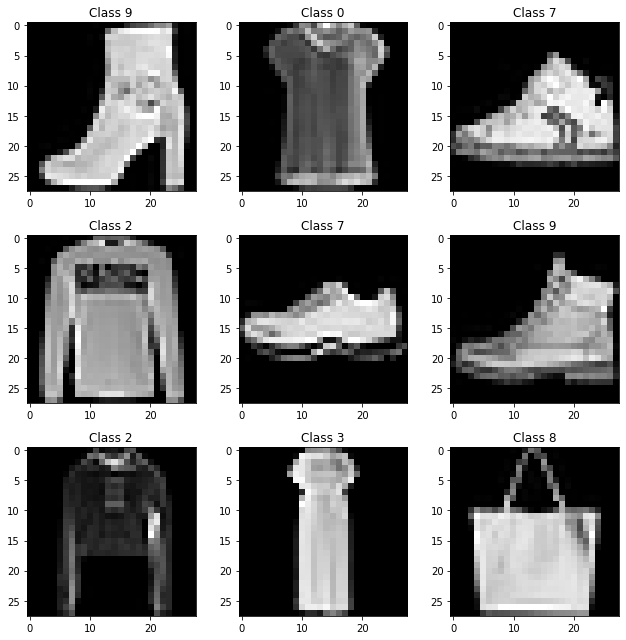

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # pour agrandir les images
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
plt.tight_layout()

In [ ]:
# Reshape and Rescale the images
X_train = X_train.reshape(-1,28,28,1) / 255.
X_test = X_test.reshape(-1,28,28,1) / 255.

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


#preparer l'autoencoder convolutif

In [ ]:
# CREER l'autoencoder convolutif     ;   autoencoder = encodeur + decodeur
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))



model.add(Conv2D(2, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))


model.add(Conv2D(2, (3,3), padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))



model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))


model.add(Conv2D(1, (3,3), padding='same', activation='relu'))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 2)         290       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 2)           38        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 2)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        3

In [ ]:
# entrainer le model
model.fit(X_train, X_train, epochs=5, batch_size=64, validation_data=(X_test, X_test), verbose=1)

Epoch 1/5
938/938 [==============================] - 73s 77ms/step - loss: 0.0209 - val_loss: 0.0163
Epoch 2/5
938/938 [==============================] - 73s 77ms/step - loss: 0.0145 - val_loss: 0.0134
Epoch 3/5
938/938 [==============================] - 74s 79ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 4/5
938/938 [==============================] - 74s 79ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 5/5
938/938 [==============================] - 74s 79ms/step - loss: 0.0118 - val_loss: 0.0117


In [ ]:
# predicter la data de test
restored_testing_dataset = model.predict(X_test)

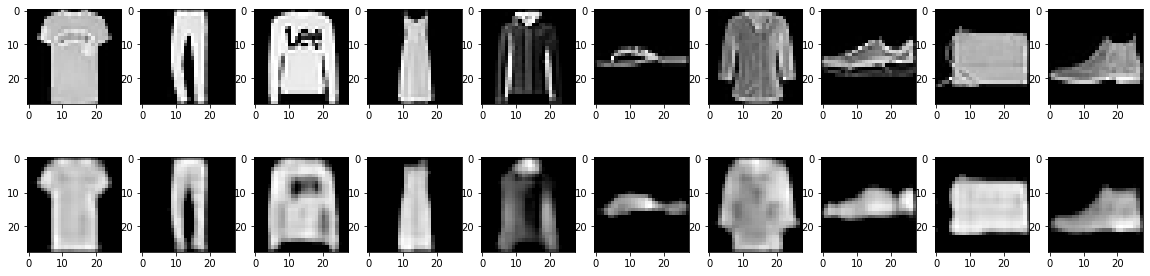

In [ ]:
# observation des images reconstructée
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

In [ ]:
# extraire l'encodeur  
encodeur = K.function([model.layers[0].input], [model.layers[4].output])

In [ ]:
# Encode the training set
images_codées = encodeur([X_test])[0].reshape(-1,7*7*2)

In [ ]:
# Cluster the training set
kmeans = KMeans(n_clusters=10,  max_iter = 1)
clustered_training_set = kmeans.fit_predict(images_codées)

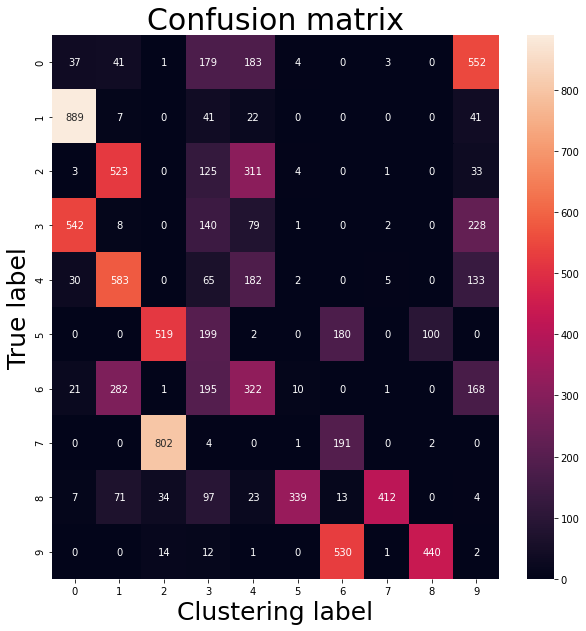

In [ ]:
# Observe and compare clustering result with actual label using confusion matrix
cm = confusion_matrix(y_test, clustered_training_set)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

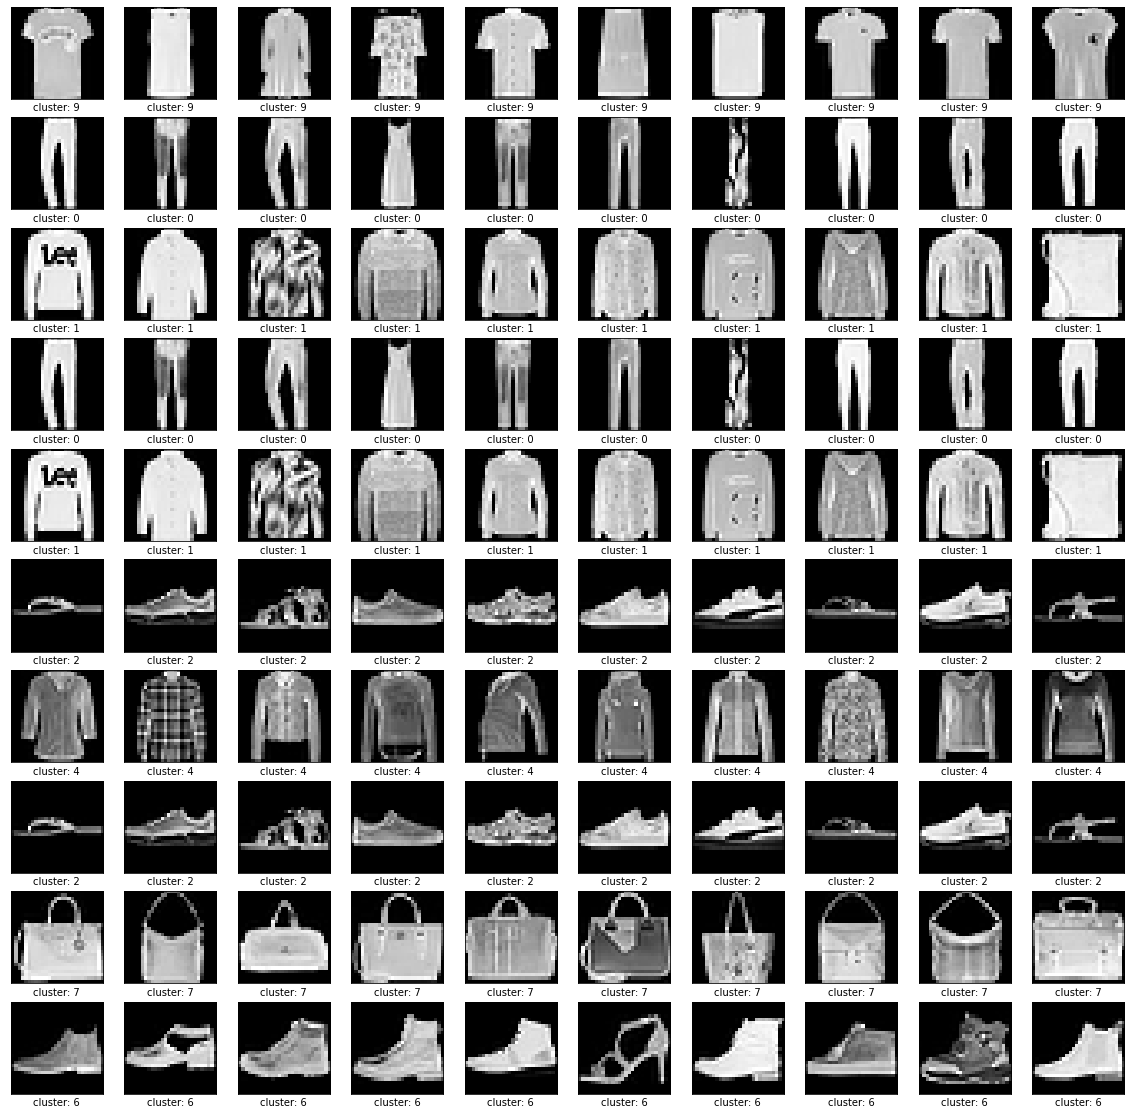

In [ ]:
# Plot the actual pictures grouped by clustering
fig = plt.figure(figsize=(20,20))
for i in range(10):
    cluster = cm[i].argmax()
    for c, val in enumerate(X_test[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*i+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))